In [1]:
from PIL import Image
import os
import json
import torch
import random
from tqdm import tqdm
from typing import List
from transformers import CLIPModel, CLIPProcessor
from torchvision import transforms

from tools import utils

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
transform = transforms.Compose([transforms.ToTensor()])

In [25]:
class Arguments:
    def __init__(self):
        self.data_root = 'data/maplm_v0.1'
        self.output_dir = 'runs'
        self.test_split = 'train'
        self.test_number = -1
        self.exp_label = 'clip'
        self.random_seed = 42
        self.debug = False

arguments = Arguments()
random.seed(arguments.random_seed)
frames, frame_ids = utils.load_data(arguments)
result_file_name = utils.get_result_file(arguments)
results = dict(
    question_overall=utils.acc_counter(),
    frame_overall=utils.acc_counter(),
)
question_prompt_map = {
    "What kind of road scene is it in the images?": "A photo of a ",
    "What is the point cloud data quality in current road area of this image?": "The point cloud is ",
    "How many lanes in current road?": ["There are ", " lanes in this road."],
    "Is there any road cross, intersection or lane change zone in the main road?": ""
}

Number of test frames: 10775



FR6


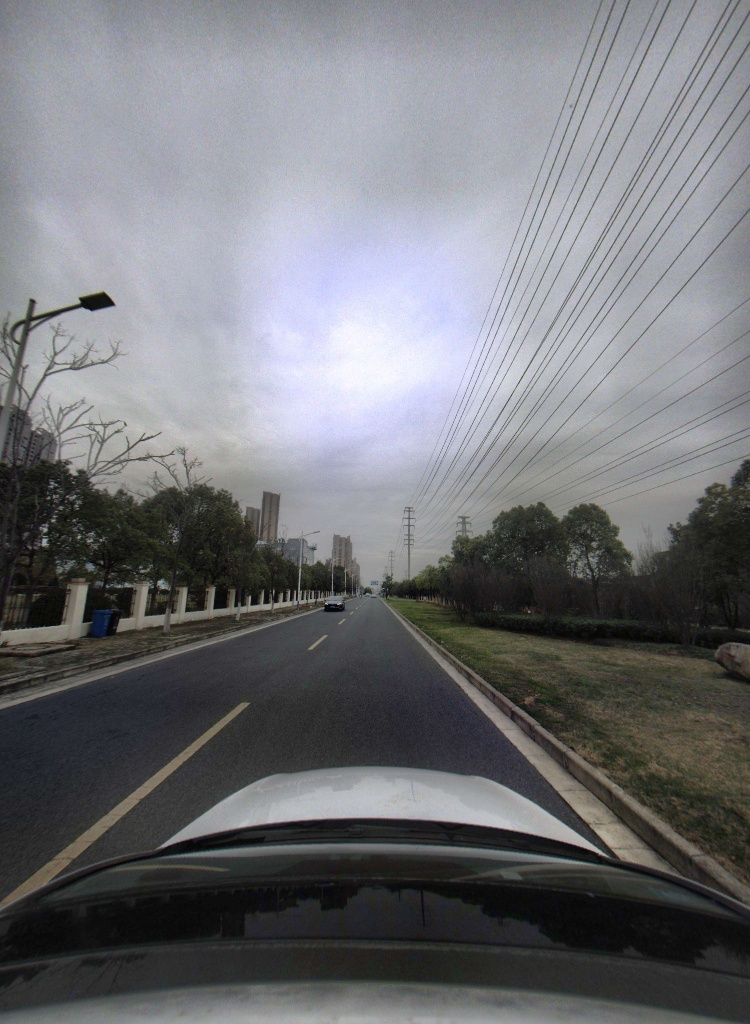

In [30]:
frame_id = frame_ids[3]
print(frame_id)

frame = frames[frame_id]

image_list = frame['image']
qas = frame['qa']

corrects = []

image_path = f'{arguments.data_root}/{arguments.test_split}/{frame_id}/{image_list[1]}'
image = Image.open(image_path)
image

In [31]:
image = transform(image).to(device)

In [36]:
for j, qa in enumerate(qas):
    if qa['task'] != 'closed choice':
        continue
    question = qa['question']
    choices: List[str] = qa['choices']
    true_answer: int = qa['answer']

    text = []
    if question == "What kind of road scene is it in the images?":
        for choice in choices:
            if "None" in choice:
                text.append(choice)
            else:
                if "Round" in choice:
                    text.append("None")
                # text.append(question_prompt_map[question] + choice)
                text.append(choice)
        print(text)
    # elif question == "What is the point cloud data quality in current road area of this image?":
    #     for choice in choices:
    #         text.append(question_prompt_map[question] + choice.replace('V', 'v').replace('N', 'n'))
    # elif question == "How many lanes in current road?":
    #     for choice in choices:
    #         text.append(question_prompt_map[question][0] + choice + question_prompt_map[question][1])
    # elif question == "Is there any road cross, intersection or lane change zone in the main road?":
    #     for choice in choices:
    #         if "Yes" in choice:
    #             text.append(choice.replace('Yes, t', 'T'))
    #         else:
    #             text.append(choice)
    else:
        continue
        
    inputs = processor(text, images=image, return_tensors="pt", padding=True)
    inputs['input_ids'] = inputs['input_ids'].to(device)
    inputs['attention_mask'] = inputs['attention_mask'].to(device)
    inputs['pixel_values'] = inputs['pixel_values'].to(device)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    print(probs)
    guess = torch.argmax(probs, dim=1).item()
    print(choices[guess])
    print(choices[true_answer])

    if question not in results:
        results[question] = utils.acc_counter()

    correct = bool(guess == true_answer)
    corrects.append(correct)

    results[question]['total'] += 1
    results[question]['correct'] += int(correct)
    results['question_overall']['total'] += 1
    results['question_overall']['correct'] += int(correct)

results['frame_overall']['total'] += 1
results['frame_overall']['correct'] += int(all(corrects))

Unused or unrecognized kwargs: padding.


['Normal city road.', 'Construction road.', 'Undeveloped road.', 'Road mark repainting.', 'None', 'Roundabout.', 'None of the above.']
tensor([[0.1547, 0.1591, 0.0282, 0.0140, 0.2864, 0.2905, 0.0672]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)
None of the above.
Normal city road.


In [ ]:
frame

{'image': ['point_cloud_bev.jpg',
  'photo_forward.jpg',
  'photo_lef_back.jpg',
  'photo_rig_back.jpg'],
 'qa': [{'question': 'What kind of road scene is it in the images?',
   'choices': ['Normal city road.',
    'Construction road.',
    'Undeveloped road.',
    'Road mark repainting.',
    'Roundabout.',
    'None of the above.'],
   'answer': 0,
   'task': 'closed choice',
   'grade': 'grade3',
   'subject': 'social science',
   'topic': 'traffic road',
   'category': 'road scene type'},
  {'question': 'What is the point cloud data quality in current road area of this image?',
   'choices': ['Very clear.',
    'Not clear, road mark is worn.',
    'Not clear, road mark is occluded by some vehicle.',
    'Not clear, road mark is worn and occluded by vehicle.'],
   'answer': 0,
   'task': 'closed choice',
   'grade': 'grade2',
   'subject': 'social science',
   'topic': 'traffic road',
   'category': 'data quality'},
  {'question': 'How many lanes in current road?',
   'choices': ['2

In [ ]:
for i, frame_id in enumerate(tqdm(frame_ids)):
    frame = frames[frame_id]

    image_list = frame['image']
    qas = frame['qa']

    corrects = []

    image_path = f'{arguments.data_root}/{arguments.test_split}/{frame_id}/{image_list[1]}'
    image = Image.open(image_path)
    image = transform(image).to(device)
    for j, qa in enumerate(qas):
        if qa['task'] != 'closed choice':
            continue
        question = qa['question']
        choices: List[str] = qa['choices']
        true_answer: int = qa['answer']

        text = []
        if question == "What kind of road scene is it in the images?":
            for choice in choices:
                if "None" in choice:
                    text.append(choice)
                else:
                    text.append(question_prompt_map[question] + choice)
        # elif question == "What is the point cloud data quality in current road area of this image?":
        #     for choice in choices:
        #         text.append(question_prompt_map[question] + choice.replace('V', 'v').replace('N', 'n'))
        # elif question == "How many lanes in current road?":
        #     for choice in choices:
        #         text.append(question_prompt_map[question][0] + choice + question_prompt_map[question][1])
        # elif question == "Is there any road cross, intersection or lane change zone in the main road?":
        #     for choice in choices:
        #         if "Yes" in choice:
        #             text.append(choice.replace('Yes, t', 'T'))
        #         else:
        #             text.append(choice)
        else:
            continue
            
        inputs = processor(text, images=image, return_tensors="pt", padding=True)
        inputs['input_ids'] = inputs['input_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        inputs['pixel_values'] = inputs['pixel_values'].to(device)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        guess = torch.argmax(probs, dim=1).item()

        if question not in results:
            results[question] = utils.acc_counter()

        correct = bool(guess == true_answer)
        corrects.append(correct)

        results[question]['total'] += 1
        results[question]['correct'] += int(correct)
        results['question_overall']['total'] += 1
        results['question_overall']['correct'] += int(correct)

    results['frame_overall']['total'] += 1
    results['frame_overall']['correct'] += int(all(corrects))

acc_dict = utils.compute_acc(results)
print(json.dumps(acc_dict, indent=4, sort_keys=True))
print(json.dumps(results, indent=4, sort_keys=True))
if not os.path.exists(arguments.output_dir):
    os.makedirs(arguments.output_dir)
with open(arguments.output_dir + '/' + result_file_name, 'w') as f:
    json.dump(results, f, indent=4, sort_keys=True)

  0%|          | 0/1500 [00:00<?, ?it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
  0%|          | 2/1500 [00:00<01:42, 14.62it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
  0%|          | 4/1500 [00:00<01:43, 14.45it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
  0%|          | 6/1500 [00:00<01:47, 13.90it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
  1%|          | 8/1500 [00:00<01:57, 12.66it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
  1%|          | 10/1500 [00:00<01:51, 13.41it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
  1%|          | 12/1500 [00:00<01:46, 13.93it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
  1%|          | 14/1500 [00:01<01:45, 14.07it/s]Unused or unrecognized kwargs: padding.
Unused or unrecognize

KeyboardInterrupt: 

In [ ]:
qas[0]

{'question': 'What kind of road scene is it in the images?',
 'choices': ['Normal city road.',
  'Construction road.',
  'Undeveloped road.',
  'Road mark repainting.',
  'Roundabout.',
  'None of the above.'],
 'answer': 0,
 'task': 'closed choice',
 'grade': 'grade3',
 'subject': 'social science',
 'topic': 'traffic road',
 'category': 'road scene type'}

In [ ]:
problems = json.load(open("data/maplm_v0.1_small/maplm_v0.1/problems.json"))
img_problem = problems["FR34"]['qa'][0]
text = []
for i in range(len(img_problem["choices"])):
    line = img_problem["question"] + " " + img_problem["choices"][i]
    text.append(line)
inputs = processor(text, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs

Unused or unrecognized kwargs: padding.


tensor([[0.2079, 0.1089, 0.3739, 0.0158, 0.1722, 0.1212]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
problems = json.load(open("data/maplm_v0.1_small/maplm_v0.1/problems.json"))
img_problem = problems["FR34"]['qa'][0]
text = []
for i in range(len(img_problem["choices"])-1):
    line = "A photo of a " + img_problem["choices"][i]
    text.append(line)
inputs = processor(text, images=image, return_tensors="pt", padding=True)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
probs

Unused or unrecognized kwargs: padding.


tensor([[0.3615, 0.2337, 0.3301, 0.0118, 0.0629]], grad_fn=<SoftmaxBackward0>)

In [ ]:
text

['A photo of a Normal city road.',
 'A photo of a Construction road.',
 'A photo of a Undeveloped road.',
 'A photo of a Road mark repainting.',
 'A photo of a Roundabout.']